# Lavaux Sensor Data: Temperature 

> LOCAL

In [21]:
import pandas as pd
import os
import glob
import numpy as np
import re
from scipy import stats
import sklearn

from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from tslearn.clustering import TimeSeriesKMeans
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
import itertools
from scipy.stats import kruskal, friedmanchisquare
from statsmodels.formula.api import mixedlm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 0. Import Temperature of all files 
readout from HOBO sensors on these dates:
1. 2022-03-08
2. 2023-05-10
3. 2023-09-20

--> First column is temperature, second one RH

In [22]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

### Sensor metadata 

In [ ]:
md = pd.read_csv('sensors_metadata.tsv', sep='\t', index_col=0)

# make dict to rename the sensor names with the plot ID 
rename_columns_dict = dict(zip(md["Sensors"], md.index))

### 1. 2021-2022

> note Lavaux_003 measured all 15 min (consider subsampling with `df['Lavaux_003'].resample('1H').mean()`)

> Sensors were installed on 2021-04-20 and read out 2022-03-08 

In [ ]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2022 = pd.concat(dfs, axis=1)
df_2022.index = pd.to_datetime(df_2022.index)

# sort by timestamp 
df_2022.sort_index(inplace=True)

# name columns 
df_2022 = df_2022.set_axis(names, axis=1)
df_2022.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2022 = df_2022[(df_2022.index > '2021-04-21 00:30:00') & (df_2022.index < '2022-03-08 08:00:00')]

### 2. 2022-2023 
> note two sensors have gone missing when reading out the sensors in 2023!

In [ ]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_1')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023 = df_2023.set_axis(names, axis=1)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_1 = df_2023[(df_2023.index > '2022-03-08 18:00:00') & (df_2023.index < '2023-05-10 08:00:00')]

### 3. 2023 
growing season of 2023, sensors were collected at harvest (2023-09-20)

In [ ]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_2')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,2], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023 = df_2023.set_axis(names, axis=1)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_2 = df_2023[(df_2023.index > '2023-05-10 09:00:00') & (df_2023.index < '2023-09-20 08:00:00')]

In [ ]:
df_2023_2.head()

### 4. Agrometeo Data for Plot 19
downloaded from: https://www.agrometeo.ch/de/meteorologie/data?stations=98&sensors=1%3Aavg,1%3Amin,1%3Amax,1%3Acumsum%3A0,4%3Aavg,4%3Amin,4%3Amax,6%3Asum&from=2021-03-08&to=2023-09-30&scale=hour&groupBy=station&measured=0

In [ ]:
agrometeo_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021/Agrometeo_BEL_all.csv', index_col=0)
agrometeo_data.index = pd.to_datetime(agrometeo_data.index, format="%d.%m.%Y %H:%M")
# Keep only the first column and rename it to 'Plot_18'
agrometeo_data = agrometeo_data.iloc[:, [0]].rename(columns={agrometeo_data.columns[0]: 'Plot_19'})

# set appropriate time frame 
agrometeo_data_time = agrometeo_data[(agrometeo_data.index > '2021-04-21 00:30:00') & (agrometeo_data.index < '2023-09-20 08:00:00')]

In [ ]:
agrometeo_data_time.head()

### Merge all data

In [ ]:
df_temp_2 = pd.concat([df_2022,df_2023_1,df_2023_2], join='outer', axis=0)
df_temp = pd.merge(df_temp, agrometeo_data_time, left_index=True, right_index=True, how='outer')

In [ ]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

# save merged data 
df_temp.to_csv('Lavaux_all_Temp_raw.csv')

In [ ]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

# get mean temperature for each month
show_temps = df_temp.resample('H').mean()

# loop over columns and plot temperatures 
for column in show_temps.columns:
    plt.plot(show_temps.index, show_temps[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

# 1. Outlier correction

### MAD 
Using  median absolute deviation (MAD) to detect outliers (maybe too stringent?). Compare each entry to 5 other entrie at the same timepoint and remove it if it is outside the specified variation.

--> assuming normal distribution the scaling factor is 1.4826 

https://en.wikipedia.org/wiki/Median_absolute_deviation

In [ ]:
MAD_threshold = 3.5

MAD_window = 24
MAD_neighbors = 5

In [ ]:
# function to compare each value to other values at this timestamp and to remove values outside of the specified threshold 

def remove_outliers(row, num_neighbors = MAD_neighbors, threshold = MAD_threshold):
    # Find non-NaN values in the row
    non_na_indices = row.dropna().index
    
    # If there are fewer than num_neighbors non-NaN values, return the original row
    if len(non_na_indices) < num_neighbors:
        return row
    
    # Extract values for comparison
    values_to_compare = row[non_na_indices].values
    
    # Calculate the median and median absolute deviation (MAD)
    median_value = np.median(values_to_compare)
    mad = np.median(np.abs(values_to_compare - median_value))
    
    # Identify indices of outliers based on the MAD and threshold
    outlier_indices = non_na_indices[np.abs(values_to_compare - median_value) > threshold * mad]
    
    # Replace outliers with NaN
    row[outlier_indices] = pd.NA
    
    return row

In [ ]:
# Remove outliers using rolling Median Absolute Deviation (MAD) for each column.

def remove_outliers_rolling(df, window_size = MAD_window, threshold = MAD_threshold):

    result_df = df.copy()

    for column in df.columns:
        column_data = df[column]

        # Use rolling median and rolling MAD
        rolling_median = column_data.rolling(window=window_size, min_periods=1, center=True).median()
        rolling_mad = column_data.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

        # Identify outliers
        outliers = np.abs(column_data - rolling_median) > threshold * rolling_mad

        # Mark outliers in the result DataFrame with NaN
        result_df.loc[outliers, column] = pd.NA

    return result_df

In [ ]:
# let's resample per hour 
df = df_temp.resample('H').mean()

# Apply the remove_outliers function to each column in the DataFrame
df_outliers_MAD = df.apply(remove_outliers, axis=1)

# Set window size and apply the function
df_outliers_rollingMAD = remove_outliers_rolling(df)

In [ ]:
## quickly show how many entries we "loose" from resampling 

original_counts = df_temp.count()
resampled_counts = df_temp.resample('H').mean().count()
MAD_counts = df_outliers_MAD.count()
MADrolling_counts = df_outliers_rollingMAD.count()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Original': original_counts, 'Resampled': resampled_counts, 'MAD_filtered' : MAD_counts, 'MADrolling_filtered' : MADrolling_counts})

# Plot the grouped bar chart
ax = plot_data.plot(kind='bar', figsize=(15, 6), color=['orange','skyblue','green', 'lightgreen'])

# Set plot labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Columns')
ax.set_title('Sample Count - Original vs Resampled vs Filtered')

# Display legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_MAD.columns:
    plt.plot(df_outliers_MAD.index, df_outliers_MAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD outliers')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

In [ ]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_rollingMAD.columns:
    plt.plot(df_outliers_rollingMAD.index, df_outliers_rollingMAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD rolling window')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

In [ ]:
# Save the outlier corrected data 
df_outliers_MAD.to_csv('Lavaux_all_Temp_OutliersRemoved.csv')
df_outliers_MAD.tail()

# 2. Comparing the years 

--> 2021 was substantially colder and 2022 particularly hot 

In [25]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

In [30]:
df = pd.read_csv('Lavaux_all_Temp_OutliersRemoved.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,Plot_18,Plot_15_3,Plot_4,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,...,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2,Plot_19
2021-04-21 00:00:00,21.96300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 01:00:00,21.94500,21.843,21.891,21.939,22.011,22.034,21.915,22.106,21.963,22.034,...,22.082,22.034,21.939,21.891,22.034,22.058,21.963,22.058,21.987,NaN
2021-04-21 02:00:00,21.90300,21.819,21.819,21.915,21.939,22.011,21.867,22.058,21.891,21.987,...,21.987,21.939,21.891,21.819,21.987,21.987,21.915,21.963,21.939,NaN
2021-04-21 03:00:00,21.84300,21.795,21.748,21.891,21.867,21.963,21.795,22.011,21.843,21.915,...,21.915,21.819,21.819,21.748,21.891,21.915,21.891,21.867,21.891,NaN
2021-04-21 04:00:00,21.79525,21.748,21.652,21.843,21.795,21.939,21.748,21.939,21.772,21.843,...,21.819,21.700,21.748,21.652,21.795,21.819,21.819,21.772,21.843,NaN


/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_96305/1718223472.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: F

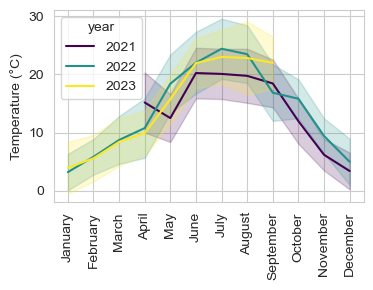

In [38]:
#df = df_outliers_MAD.copy()

# Extract year and month from the timestamp
df['year'] = df.index.year
df['month'] = df.index.month
df_melted = pd.melt(df, id_vars=['year', 'month'], var_name='temperature_type', value_name='temperature')

# Create a line plot with shaded area using seaborn
plt.figure(figsize=(4,2.5))

sns.set_style("whitegrid")

sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
#plt.title('Temperature Variation Over 12 Months (Min-Median-Max)')
plt.xlabel('')
plt.ylabel('Temperature (°C)')

# Customize x-axis ticks for every month
plt.xticks(range(1, 13), [pd.to_datetime(str(i), format='%m').strftime('%B') for i in range(1, 13)])
plt.xticks(rotation=90)

plt.show()

# 3. Interplot variance

### Statistical testing 

> mean temperatures of months / weeks **are not** statistically significant between each other 

In [ ]:
df = df_outliers_MAD

In [ ]:
# Perform Kruskal-Wallis test on each row
p_values = []
for _, row in df.iterrows():
    _, p_value = stats.kruskal(*row.values)
    p_values.append(p_value)

# Create a new DataFrame with p-values
p_value_df = pd.DataFrame({'P-Value': p_values}, index=df.index)

# Filter and print rows with significant p-values
significant_rows = p_value_df[p_value_df['P-Value'] < 0.05]
print(significant_rows)

### Add some metadata

In [ ]:
# Merge the dataframes based on the sensor name (reset the index first) and sort: first by altitude and then by plot 
ave_temp_new = df_outliers_MAD.reset_index() 
md_renamed = md.reset_index()
merged_df = ave_temp_new.melt(id_vars='index', var_name='ID', value_name='Temperature').merge(md, on='ID').sort_values(by = ['Altitude', 'ID'])

### Boxplots

In [ ]:
plt.figure(figsize=(10,5))

plots_ordered_by_altitude = [17, 5, 14, 4, 18, 20, 18, 11, 19, 9, 12, 15, 13]

ax = sns.boxplot(x='ID', y='Temperature', hue="Plots", 
                 width=0.8, dodge=False,
                 data=merged_df, palette="husl", 
                 hue_order=plots_ordered_by_altitude,
                 showfliers = False
                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Box plots of temperatures for plots ordered by altitude')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
)
None
# the None is to not show the lables as output 

### Heatmaps

In [ ]:
df = df_outliers_MAD.copy()

# Extract unique plot names
plot_names = set('_'.join(col.split('_')[:2]) for col in df.columns)
plot_names

# Calculate median for each group of columns with the same plot name
median_values = {}
for plot_name in plot_names:
    columns = [col for col in df.columns if plot_name in col]
    median_values[plot_name] = df[columns].median(axis=1)

# Concatenate median values into a new DataFrame
df_median = pd.DataFrame(median_values)

In [ ]:
# Create heatmap
df_heatmap = df_median.T

# Get month names
monthly = df_median.resample('M').mean()
month_names = monthly.index.strftime('%B, %Y')

# Heatmap 
plt.figure(figsize=(20, 5), dpi=1000)
heatmap = sns.heatmap(data=df_heatmap, cmap='coolwarm', annot=None, 
                      cbar_kws={'label': 'Temperature [°C]', 'shrink': 0.7, 'aspect': 15, 'pad': 0.02})
#plt.title('Heatmap of all plots over the years')

# Set custom x-axis labels
n = len(month_names)
heatmap.set_xticks(np.linspace(0, n - 1, n))
heatmap.set_xticklabels(month_names)

# Calculate positions for the labels
width = heatmap.get_xlim()[1] - heatmap.get_xlim()[0]
positions = np.linspace(heatmap.get_xlim()[0], heatmap.get_xlim()[1], len(month_names))

# Set label positions
plt.xticks(positions, month_names)

plt.tight_layout()
plt.show()

# 4. Intraplot variance

Plots 15, 17 and 20 have 5 sensors each and we can test whether the mean temperature per month is statistically significant between those sensors. 

> does not look like it

In [ ]:
# Get a list of sensors at a specific plot and subset the datafame to only contain data from these plots 
plot_of_interest = 17

selected_plots = md.loc[md['Plots'] == plot_of_interest].index.to_list()
df_subset = df_outliers_removed[selected_plots]

# get mean temperature for each month (dropNA to do a significance test)
average_temps_subset = df_subset.resample('D').mean() #.dropna()

In [ ]:
average_temps_subset.head(30)

In [ ]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

for column in average_temps_subset.columns:
    plt.plot(average_temps_subset.index, average_temps_subset[column], label=column)

plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
average_temps_subset.boxplot()

plt.xticks(rotation=90)
plt.xlabel('Sensor')
plt.ylabel('Average Monthly Temperatures')
title = 'Average Temperatures of the Sensors in Plot ' + str(plot_of_interest)
plt.title(title)

plt.show()


In [ ]:
# compare min and max temperatures 
daily_max = df_subset.resample('D').max().dropna()
daily_min = df_subset.resample('D').min().dropna()

# two plots next to each other 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Create the first box plot on the first axes
daily_max.boxplot(ax=axs[0])

# Create the second box plot on the second axes
daily_min.boxplot(ax=axs[1])

# Set the title for each plot
axs[0].set_title('Max Temp')
axs[1].set_title('Min Temp')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# 5. Growing Degree Days 


2. filter for season (1. april - 30. sept)
3. filter so samples have at least 90 % of measurements for that period 
4. GDD with max and min of each day 


In [ ]:
# subset to season
df_21 = df_outliers_MAD[(df_outliers_MAD.index > '2021-04-01') & (df_outliers_MAD.index < '2021-09-30')]
df_22 = df_outliers_MAD[(df_outliers_MAD.index > '2022-04-01') & (df_outliers_MAD.index < '2022-09-30')]
df_23 = df_outliers_MAD[(df_outliers_MAD.index > '2023-04-01') & (df_outliers_MAD.index < '2023-09-30')]

In [ ]:
# Function to filter columns with >90% data coverage
def filter_columns_with_data(df, start_date, end_date, threshold=0.9):
    # Subset data for the growing season
    df_season = df[(df.index >= start_date) & (df.index <= end_date)]
    # Resample to daily counts
    daily_counts = df_season.resample('D').count()
    # Calculate the percentage of days with data for each column
    days_in_season = len(daily_counts)
    valid_columns = daily_counts.sum() / days_in_season > threshold
    return df_season.loc[:, valid_columns]

# Function to calculate GDD per plot using Tmin and Tmax
def calculate_gdd_tmin_tmax(df_tmin, df_tmax, base_temp=10):
    # Resample Tmin and Tmax to daily values
    daily_tmin = df_tmin.resample('D').mean()
    daily_tmax = df_tmax.resample('D').mean()
    
    # Calculate daily mean temperature using Tmin and Tmax
    daily_mean_temp = (daily_tmin + daily_tmax) / 2
    
    # Calculate GDD for each plot
    gdd = ((daily_mean_temp - base_temp).clip(lower=0)).sum(axis=0)
    
    # Replace plots without data (all NaN) with NaN GDD
    gdd[daily_mean_temp.isna().all()] = None
    
    return gdd


In [ ]:
# Remove plots with insufficient data (90% of data)
df_21_cleaned = filter_columns_with_data(df_21, '2021-04-01', '2021-09-30')
df_22_cleaned = filter_columns_with_data(df_22, '2022-04-01', '2022-09-30')
df_23_cleaned = filter_columns_with_data(df_23, '2023-04-01', '2023-09-30')


# Calculate GDD per plot for each year
gdd_21 = calculate_gdd(df_21_cleaned)
gdd_22 = calculate_gdd(df_22_cleaned)
gdd_23 = calculate_gdd(df_23_cleaned)

# Convert GDD to DataFrames for each year
gdd_21_df = gdd_21.to_frame(name='GDD_2021')
gdd_22_df = gdd_22.to_frame(name='GDD_2022')
gdd_23_df = gdd_23.to_frame(name='GDD_2023')

# Combine GDDs into a single DataFrame (Format 1)
gdd_combined = pd.DataFrame({
    'GDD_2021': gdd_21,
    'GDD_2022': gdd_22,
    'GDD_2023': gdd_23})

# Calculate Z-scores for all three years (GDD_2021, GDD_2022, GDD_2023)
gdd_combined['zscore_2021'] = zscore(gdd_combined['GDD_2021'], nan_policy='omit')
gdd_combined['zscore_2022'] = zscore(gdd_combined['GDD_2022'], nan_policy='omit')
gdd_combined['zscore_2023'] = zscore(gdd_combined['GDD_2023'], nan_policy='omit')

# Create a copy of the data to apply outlier filtering
gdd_combined_filtered = gdd_combined.copy()

# Apply outlier filtering to each column (year) individually
gdd_combined_filtered.loc[abs(gdd_combined_filtered['zscore_2021']) > 3, 'GDD_2021'] = np.nan
gdd_combined_filtered.loc[abs(gdd_combined_filtered['zscore_2022']) > 3, 'GDD_2022'] = np.nan
gdd_combined_filtered.loc[abs(gdd_combined_filtered['zscore_2023']) > 3, 'GDD_2023'] = np.nan

# Drop the Z-score columns if needed
gdd_combined_filtered.drop(columns=['zscore_2021', 'zscore_2022', 'zscore_2023'], inplace=True)

# Melt the DataFrame into a long format (Format 2)
gdd_long = gdd_combined_filtered.reset_index().melt(
    id_vars='index', 
    var_name='Year', 
    value_name='GDD')
# Rename columns for clarity in long format
gdd_long.rename(columns={'index': 'Plot'}, inplace=True)
gdd_long['Year'] = gdd_long['Year'].str.replace('GDD_', '')  


In [ ]:
gdd_combined_filtered

In [ ]:
gdd_long

In [ ]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=gdd_combined_filtered, showfliers=True, palette='Blues') 

plt.xlabel('Years')
plt.ylabel('Growing Degree Days')
plt.title('')

# Show the plot
plt.show()

In [ ]:
# Create a figure and axis
plt.figure(figsize=(6, 6))

# Plot the heatmap using imshow
cax = plt.imshow(gdd_combined_filtered, cmap='coolwarm', aspect='auto')

# Add colorbar
plt.colorbar(cax)

# Annotate the cells with the values
for i in range(gdd_combined_filtered.shape[0]):
    for j in range(gdd_combined_filtered.shape[1]):
        value = gdd_combined_filtered.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f'{value:.0f}', ha='center', va='center', color='black')

# Set axis labels (optional)
plt.xticks(ticks=np.arange(gdd_combined_filtered.shape[1]), labels=gdd_combined_filtered.columns, rotation=45)
plt.yticks(ticks=np.arange(gdd_combined_filtered.shape[0]), labels=gdd_combined_filtered.index)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Plot')
plt.title('GDD Heatmap')

plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background to white

# Show the plot
plt.tight_layout()
plt.show()

# Get other metrics

In [ ]:
# drop the sensor for Plot17_3 from the 2023 dataset because it's flawed
df_23_cleaned.drop(columns=['Plot_17_3'], inplace=True) 


In [ ]:
# Helper function to calculate temperature metrics for each plot
def calculate_temperature_metrics(df, year):
    # Resample to daily data if needed (assumed hourly data for this example)
    df_daily = df.resample('D').mean()  # Resampling to daily averages

    # Calculate required metrics for each plot
    metrics = pd.DataFrame(index=df.columns)  # Plot IDs as index
    
    #metrics['average_temperature'] = df_daily.mean()  # Daily average
    metrics['median_temperature'] = df_daily.median()  # Daily average
    metrics['maximum_temperature'] = df_daily.max()  # Maximum temperature
    metrics['minimum_temperature'] = df_daily.min()  # Minimum temperature
    metrics['accumulated_temperature'] = df_daily.sum()  # Accumulated temperature
    
     # Calculate coefficient of variation (CV)
    metrics['cv_temperature'] = df_daily.std() / df_daily.mean() * 100  # CV as percentage
    
    metrics['Year'] = int(year)  # Add the year for each metric (useful for merging later)

    # Reset index and rename the index to 'Plot'
    metrics.reset_index(inplace=True)
    metrics.rename(columns={'index': 'Plot'}, inplace=True)

    return metrics

# Calculate metrics for each year
temp_metrics_21 = calculate_temperature_metrics(df_21_cleaned, 2021)
temp_metrics_22 = calculate_temperature_metrics(df_22_cleaned, 2022)
temp_metrics_23 = calculate_temperature_metrics(df_23_cleaned, 2023)


In [ ]:
# combine the dfs for different years 
temp_metrics_combined = pd.concat([temp_metrics_21, temp_metrics_22, temp_metrics_23], ignore_index=True)
temp_metrics_combined.tail()

In [ ]:
# merge with GDD df 
gdd_long['Year'] = gdd_long['Year'].astype(int)
Temp_all_metrics = pd.merge(gdd_long, temp_metrics_combined, on=['Plot', 'Year'], how='outer')

In [ ]:
# get median of the replicate plots 
Temp_metrics_median = Temp_all_metrics.copy()

Temp_metrics_median['Base_Plot'] = Temp_metrics_median['Plot'].str.extract(r'(Plot_\d+)')
Temp_metrics_median = Temp_metrics_median.drop(columns=('Plot'))

grouped_df = Temp_metrics_median.groupby(['Base_Plot', 'Year']).median().reset_index()
grouped_df = grouped_df.rename(columns={'Base_Plot': 'Plot'})

grouped_df.to_csv('Lavaux_all_Temp_Metrics.csv')

#### some plotting

In [ ]:

# Assuming Temp_all_metrics is your DataFrame
# Pivot the data to have years as columns and plots as rows
temp_pivot = Temp_all_metrics.pivot(index='Plot', columns='Year', values='average_temperature')

# Create a figure and axis
plt.figure(figsize=(8, 10))  # Adjusted size for potentially more plots

# Plot the heatmap using imshow
cax = plt.imshow(temp_pivot, cmap='coolwarm', aspect='auto')

# Add colorbar
cbar = plt.colorbar(cax)
cbar.set_label('Average Temperature (°C)', rotation=270, labelpad=15)

# Annotate the cells with the values
for i in range(temp_pivot.shape[0]):
    for j in range(temp_pivot.shape[1]):
        value = temp_pivot.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='black')

# Set axis labels
plt.xticks(ticks=np.arange(temp_pivot.shape[1]), labels=temp_pivot.columns, rotation=0)
plt.yticks(ticks=np.arange(temp_pivot.shape[0]), labels=temp_pivot.index)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Plot')
plt.title('Average Temperature Heatmap')

plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background to white

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:

# Assuming Temp_all_metrics is your DataFrame
# Pivot the data to have years as columns and plots as rows
temp_pivot = Temp_all_metrics.pivot(index='Plot', columns='Year', values='median_temperature')

# Create a figure and axis
plt.figure(figsize=(8, 10))  # Adjusted size for potentially more plots

# Plot the heatmap using imshow
cax = plt.imshow(temp_pivot, cmap='coolwarm', aspect='auto')

# Add colorbar
cbar = plt.colorbar(cax)
cbar.set_label('Average Temperature (°C)', rotation=270, labelpad=15)

# Annotate the cells with the values
for i in range(temp_pivot.shape[0]):
    for j in range(temp_pivot.shape[1]):
        value = temp_pivot.iloc[i, j]
        if not np.isnan(value):
            plt.text(j, i, f'{value:.1f}', ha='center', va='center', color='black')

# Set axis labels
plt.xticks(ticks=np.arange(temp_pivot.shape[1]), labels=temp_pivot.columns, rotation=0)
plt.yticks(ticks=np.arange(temp_pivot.shape[0]), labels=temp_pivot.index)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Plot')
plt.title('Average Temperature Heatmap')

plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background to white

# Show the plot
plt.tight_layout()
plt.show()


# Statistical Testing of Temp metrics 

In [ ]:
Temp_all_metrics.head()

In [ ]:
df = Temp_all_metrics.copy()

# Ensure numeric columns
numeric_cols = ["GDD", "average_temperature", "median_temperature", "maximum_temperature", "minimum_temperature", "accumulated_temperature", "cv_temperature"]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows with NaN in metrics
df = df.dropna(subset=numeric_cols)

# Extract base plot
df['Base_Plot'] = df['Plot'].str.extract(r'(Plot_\d+)', expand=False)

df.head()

### Kruskal Wallis test to test inter-plot variation 

In [ ]:
# Inter-plot variation: within a year
inter_plot_results = {}
for year, group in df.groupby("Year"):
    grouped = group.groupby("Base_Plot")[numeric_cols].median()  # Median for plots with multiple measurements
    for metric in numeric_cols:
        stat, p = kruskal(*[grouped.loc[g][metric] for g in grouped.index])
        inter_plot_results[(year, metric)] = p

inter_plot_df = pd.DataFrame.from_dict(inter_plot_results, orient="index", columns=["p-value"])
inter_plot_df

### Mixed-Effects Model Test for Inter-Plot Variation Across Years

In [ ]:
# 2. Inter-plot variation across years
# Mixed-effects model: Plot as fixed, Year as random
inter_year_results = {}

for metric in ["GDD", "average_temperature", "median_temperature", "maximum_temperature", "minimum_temperature", "accumulated_temperature", "cv_temperature"]:
    model = mixedlm(f"{metric} ~ Base_Plot", df, groups=df["Year"])
    result = model.fit()
    inter_year_results[metric] = result.pvalues

inter_year_df = pd.DataFrame(inter_year_results)
# Format p-values to 4 decimal places
inter_year_df = inter_year_df.applymap(lambda x: round(x, 4))

inter_year_df

### Intra-plot variation 

In [ ]:
# only for plots with multiple sensors
filtered_df = df.groupby(["Base_Plot", "Year"]).filter(lambda x: len(x) > 1)
print(filtered_df.groupby(["Base_Plot", "Year"]).size())

In [ ]:
filtered_df.head()

In [ ]:

# List of numeric columns to analyze
numeric_cols = ["GDD", "average_temperature", "median_temperature", "maximum_temperature", "minimum_temperature", "accumulated_temperature", "cv_temperature"]

intra_plot_results = {}
for year, group in filtered_df.groupby("Year"):
    # Group by Base_Plot
    grouped = group.groupby("Base_Plot")
    
    for metric in numeric_cols:
        p_values = []
        
        # Iterate over each Base_Plot group
        for base_plot, data in grouped:
            p_values.append(data[metric])
        
        # Apply Kruskal-Wallis test
        stat, p = kruskal(*p_values)
        
        # Store p-value for each year and metric
        intra_plot_results[(year, metric)] = p

# Convert the results into a DataFrame
intra_plot_df = pd.DataFrame.from_dict(intra_plot_results, orient="index", columns=["p-value"])

# Display the results
intra_plot_df


In [ ]:
def analyze_plot_per_year(plot_data, numeric_cols):
    results = {}
    for year in plot_data['Year'].unique():
        year_data = plot_data[plot_data['Year'] == year]
        for metric in numeric_cols:
            # Perform Kruskal-Wallis test across replicate measurements for each metric and year
            groups = [group[metric].dropna() for _, group in year_data.groupby('Plot')]
            if len(groups) > 1 and all(len(g) > 0 for g in groups):  # Ensure we have at least 2 groups with data
                stat, p = kruskal(*groups)
                results[f"{metric}_{year}"] = p
            else:
                results[f"{metric}_{year}"] = None  # Not enough data for comparison
    return results

# Perform analysis for each Base_Plot
for base_plot in filtered_df['Base_Plot'].unique():
    plot_data = filtered_df[filtered_df['Base_Plot'] == base_plot]
    
    # Perform analysis
    plot_results = analyze_plot_per_year(plot_data, numeric_cols)
    
    # Create DataFrame for this plot
    plot_df = pd.DataFrame.from_dict(plot_results, orient="index", columns=["p-value"])
    
    # Round p-values to 4 decimal places
    plot_df = plot_df.applymap(lambda x: round(x, 4) if x is not None else x)
    
    # Sort the index to group metrics by year
    plot_df = plot_df.sort_index()
    
    # Assign the DataFrame to a dynamically named variable
    globals()[f"intra_Plot_{base_plot}"] = plot_df
    
    # Print or display the results
    print(f"Results for Plot {base_plot}:")
    print(plot_df)
    print("\n")
